Following [ResNet for MNIST with pytorch](https://www.kaggle.com/readilen/resnet-for-mnist-with-pytorch?scriptVersionId=6942243), using the MNIST dataset from torchvision.datasets instead of csv files.

### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt

### Preparing dataset

In [2]:
# loading data
mnist_data = MNIST(root='../mnist/')

In [3]:
mnist_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../mnist/
    Split: Train

In [4]:
# seeing what dtype it returns
type(mnist_data)

torchvision.datasets.mnist.MNIST

In [5]:
# spliting data into x_data (features) and y_data(labels)
# normalizing x_data
x_data = mnist_data.data/255.
y_data = mnist_data.targets

In [6]:
# Spliting into train and test datasets. Size of train data is 85% and size of test data is 15%.
# random_state=42
features_train, features_test, targets_train, targets_test = train_test_split(x_data, y_data, test_size = 0.15, random_state = 42)

In [7]:
# Spliting into train and test datasets. Size of train data is 80% and size of test data is 20%.
# random_state=42
features_train, features_test, targets_train, targets_test = train_test_split(x_data, y_data, test_size = 0.20, random_state = 42)

In [8]:
print(f'Features train size: {list(features_train.size())}')
print(f'Features test size: {list(features_test.size())}')
print(f'Targets train size: {list(targets_train.size())}')
print(f'Targets test size: {list(targets_test.size())}')

Features train size: [48000, 28, 28]
Features test size: [12000, 28, 28]
Targets train size: [48000]
Targets test size: [12000]


In [9]:
# seeing features dtype 
features_test.dtype

torch.float32

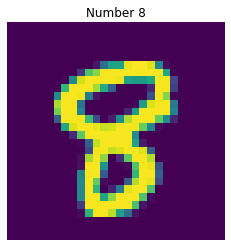

In [10]:
plt.imshow(features_train[12])
plt.axis("off")
plt.title("Number " + str(int(targets_train[12])))
plt.show() 

### Creating ResNet Model

In [11]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, 
                     out_channels, 
                     kernel_size=3, 
                     stride=stride, 
                     padding=1, 
                     bias=False)

<b><span style="color:blue">Study notes:</span></b><br>
[Conv2d](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html) parameters:

- **in_channels (int)** – Number of channels in the input image
- **out_channels (int)** – Number of channels produced by the convolution
- **kernel_size (int or tuple)** – Size of the convolving kernel
- **stride (int or tuple, optional)** – Stride of the convolution. Default: 1
- **padding (int or tuple, optional)** – Zero-padding added to both sides of the input. Default: 0
- **padding_mode (string, optional)** – 'zeros', 'reflect', 'replicate' or 'circular'. Default: 'zeros'
- **dilation (int or tuple, optional)** – Spacing between kernel elements. Default: 1 
- **groups (int, optional)** – Number of blocked connections from input channels to output channels. Default: 1
- **bias (bool, optional)** – If True, adds a learnable bias to the output. Default: True

In this function, a 2d convolution is applied, the kernel size is 3x3 with initially a stride of 1 (can be specified a different value). There is a padding of 0s (1 pixel border).

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            residual = self.downsample(x)
            
        out += residual
        out = self.relu(out)
        
        return out

<b><span style="color:blue">Study notes:</span></b><br>

On [this medium article (Residual blocks — Building blocks of ResNet)](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec) there's a bit about what is a residual block.

![Image](https://miro.medium.com/max/700/1*FqmD91PvbH7NKCnQWFJxvg.png)

<center> Types of Residual Block. Source: <a href="https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec"> Residual blocks - Building blocks of ResNet </a></center>

In `__init__`:
- 3x3 convolution;
- [Batch normalization](https://arxiv.org/abs/1502.03167), size of out_channels and output is the same shape as input;
- Rectified linear unit function (operation in-place);
- 3x3 convolution, size of channels of input is the same as output channels size (produced by the convolution;
- Batch normalization;
- Downsample (uses nn.Sequential later on)

In [13]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[0], 2)
        self.layer3 = self.make_layer(block, 64, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
    
    def make_layer(self, block, out_channels, blocks, stride=1):
        
        downsample = None
        
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        
        return out

### Training the Model

In [14]:
batch_size = 100
n_iters = 2500
num_epochs = n_iters/ (len(features_train) / batch_size)

In [15]:
num_epochs = int(num_epochs)
num_epochs

5

In [16]:
train = torch.utils.data.TensorDataset(features_train, targets_train)
test = torch.utils.data.TensorDataset(features_test, targets_test)

In [17]:
train

In [18]:
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle=False)

In [19]:
train_loader.sampler

In [20]:
train_loader.batch_size

100

In [21]:
train_loader.dataset

In [22]:
net_args = {
    "block": ResidualBlock,
    "layers": [2,2,2,2]
}

model = ResNet(**net_args)

In [23]:
error = nn.CrossEntropyLoss()

In [24]:
learning_rate = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
loss_list = []
iteration_list = []
accuracy_list = []
count = 0

In [29]:
for epoch in range(num_epochs):
    print(f'epoch {epoch + 1} out of {num_epochs}')
    
    for i, (images, labels) in enumerate(train_loader):
        train  = Variable(images.resize_(batch_size, 1, 32, 32))
        labels = Variable(labels)           
        
        # Clear gradients
        optimizer.zero_grad()   
        
        # Forward propagation
        outputs = model(train)      
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)   
        
        # Calculating gradients
        loss.backward()   
        
        # Update parameters
        optimizer.step()  
        
        count += 1      
        if count % 250 == 0:
            correct = 0
            total = 0

            for images, labels in test_loader:
                images = Variable(images.resize_(batch_size, 1, 32, 32))                
                outputs = model(images)                
                predicted = torch.max(outputs.data, 1)[1]                
                total += labels.size(0)              
                correct += (predicted == labels).sum()         
            
            accuracy = 100 * correct / float(total)           

            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data.item(), accuracy))

epoch 1 out of 5
Iteration: 2250  Loss: 2.3137640953063965  Accuracy: 11.016666412353516 %
Iteration: 2500  Loss: 2.3097715377807617  Accuracy: 11.016666412353516 %
epoch 2 out of 5
Iteration: 2750  Loss: 2.3192617893218994  Accuracy: 11.016666412353516 %
Iteration: 3000  Loss: 2.3143579959869385  Accuracy: 10.824999809265137 %
epoch 3 out of 5
Iteration: 3250  Loss: 2.3006138801574707  Accuracy: 9.783333778381348 %
Iteration: 3500  Loss: 2.300628185272217  Accuracy: 11.033333778381348 %
epoch 4 out of 5
Iteration: 3750  Loss: 2.3050332069396973  Accuracy: 9.641666412353516 %
epoch 5 out of 5
Iteration: 4000  Loss: 2.3042969703674316  Accuracy: 9.783333778381348 %
Iteration: 4250  Loss: 2.3264737129211426  Accuracy: 9.800000190734863 %


**1st attempt:**

Did it wrong, iterations passed 2000.

**2nd-4th attempt:**

`Loss:nan`

**5th attempt:**

Test: 15%, Train: 85%, for some weird reason the accuracy stayed the same.
```
0 4 (epoch/num_epochs)
Iteration: 250  Loss: nan  Accuracy: 9.899999618530273 %
Iteration: 500  Loss: nan  Accuracy: 9.899999618530273 %
1 4
Iteration: 750  Loss: nan  Accuracy: 9.899999618530273 %
Iteration: 1000  Loss: nan  Accuracy: 9.899999618530273 %
2 4
Iteration: 1250  Loss: nan  Accuracy: 9.899999618530273 %
Iteration: 1500  Loss: nan  Accuracy: 9.899999618530273 %
3 4
Iteration: 1750  Loss: nan  Accuracy: 9.899999618530273 %
Iteration: 2000  Loss: nan  Accuracy: 9.899999618530273 %
```


**Final attempt:**

Test: 20%, Train: 80%.
```
epoch 0 out of 5
Iteration: 250  Loss: 2.3006722927093506  Accuracy: 10.158333778381348 %
Iteration: 500  Loss: 2.3206615447998047  Accuracy: 10.158333778381348 %
epoch 1 out of 5
Iteration: 750  Loss: 2.302372932434082  Accuracy: 10.216666221618652 %
epoch 2 out of 5
Iteration: 1000  Loss: 2.2932326793670654  Accuracy: 10.166666984558105 %
Iteration: 1250  Loss: 2.292675495147705  Accuracy: 10.091666221618652 %
epoch 3 out of 5
Iteration: 1500  Loss: 2.302126407623291  Accuracy: 10.158333778381348 %
Iteration: 1750  Loss: 2.3060832023620605  Accuracy: 10.158333778381348 %
epoch 4 out of 5
Iteration: 2000  Loss: 2.293761730194092  Accuracy: 10.149999618530273 %
Iteration: 2250  Loss: 2.317558526992798  Accuracy: 10.158333778381348 %
```



<span style="color: blue"><b>Study session observations:</b></span><br>
<sub>A place for study sessions' observations/thoughts. At a new commit, the previous input will be commented, therefore hidden.</sub>

***
<!-- #### 15/07/2020:

A bit confused about the model used, it's very much a black box where I can see the results and then somewhat understand, but I can't really replicate it. In the previous days, I tried first implementing it, just to see it in action, and now I'm trying to understand more about it.

I think the first part of understanding is to search a bit more about the objects that I am using. I don't understand much about the objects themselves, what I can do with them and more. Today I tried to learn a bit more about the classes `torch.nn.modules.conv.Conv2d` and `torch.nn.modules.batchnorm.BatchNorm2d`. Might look into creating a different notebook in order to try to use the model and objects in different ways and also since this one is starting to get a bit polluted. -->

<!-- #### 16/07/2020:

Testing functions and methods moved to a different notebook. Tried increasing the number of epochs to 20 to see if the accuracy would change.  -->